In [1]:
import glob
import subprocess

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
dfs = [
    pd.DataFrame(dict(h5py.File(filename, "r")))
    for filename in sorted(
        glob.glob("/home/jpivarski/storage/data/GHArchive/GHArchive-*-aggregated.h5")
    )
]
for df, year in zip(dfs, range(2015, 2323 + 1)):
    df["year"] = year
df = pd.concat(dfs, ignore_index=True)
del dfs

In [3]:
df

,actor_id,count,event_type_id,repo_id,year
0,13203,1,20,1,2015
1,14975,1,20,1,2015
2,27893,1,7,1,2015
3,27893,1,20,1,2015
4,31752,2,10,1,2015
...,...,...,...,...,...
1235832676,54982819,3,2,634695657,2023
1235832677,54982819,1,17,634695657,2023
1235832678,72999089,1,2,634695659,2023
1235832679,123601168,1,2,634695660,2023


Look at a few Scikit-HEP repos, which we understand to be typical software libaries and we know who the authors are.

In [4]:
df_few = df[
    #               particle                      vector                        pyhf             boost-histogram                   cabinetry                     fastjet                         hist                  iminuit
    (df.repo_id == 158364052) | (df.repo_id == 217698030) | (df.repo_id == 118789569) | (df.repo_id == 148885351) | (df.repo_id == 259414004) | (df.repo_id == 358288382) | (df.repo_id == 239605861) | (df.repo_id == 7228447)
].drop(columns=["repo_id"]).groupby(["actor_id", "event_type_id"]).sum().drop(columns=["year"]).reset_index()
df_few

,actor_id,event_type_id,count
0,3856,20,1
1,8851,10,2
2,15233,20,1
3,23151,10,1
4,45071,10,7
...,...,...,...
1725,123247611,20,2
1726,127864190,10,1
1727,127864190,11,1
1728,127886291,20,1


Select the audience of these repos: not bots and not the authors.

In [5]:
df_audience = df_few[
    #             dependabot[bot]              pre-commit-ci[bot]            azure-pipelines[bot]                sourcery-ai[bot]            allcontributors[bot]            allcontributors[bot]
    (df_few.actor_id != 49699333) & (df_few.actor_id != 66853113) & (df_few.actor_id != 36771401) & (df_few.actor_id != 58596630) & (df_few.actor_id != 34387503) & (df_few.actor_id != 46447321) &
    #                   henryiii             eduardo-rodrigues                     Saransh-cpp                      jpivarski
    (df_few.actor_id != 4616906) & (df_few.actor_id != 5013581) & (df_few.actor_id != 74055102) & (df_few.actor_id != 1852447) &
    #            matthewfeickert                 lukasheinrich                        kratsg                  alexander-held
    (df_few.actor_id != 5142394) & (df_few.actor_id != 2318083) & (df_few.actor_id != 761483) & (df_few.actor_id != 45009355) &
    #                  aryan26roy                   LovelyBuggies                    amangoel185                     HDembinski                        piti118                          cdeil
    (df_few.actor_id != 50577809) & (df_few.actor_id != 29083689) & (df_few.actor_id != 10528392) & (df_few.actor_id != 2631586) & (df_few.actor_id != 591316) &  (df_few.actor_id != 852409)
]

Select the authors, not bots.

In [6]:
df_author = df_few[
    #             dependabot[bot]              pre-commit-ci[bot]            azure-pipelines[bot]                sourcery-ai[bot]            allcontributors[bot]            allcontributors[bot]
    (df_few.actor_id != 49699333) & (df_few.actor_id != 66853113) & (df_few.actor_id != 36771401) & (df_few.actor_id != 58596630) & (df_few.actor_id != 34387503) & (df_few.actor_id != 46447321) &  (
    #                   henryiii             eduardo-rodrigues                     Saransh-cpp                      jpivarski
    (df_few.actor_id == 4616906) | (df_few.actor_id == 5013581) | (df_few.actor_id == 74055102) | (df_few.actor_id == 1852447) |
    #            matthewfeickert                 lukasheinrich                        kratsg                  alexander-held
    (df_few.actor_id == 5142394) | (df_few.actor_id == 2318083) | (df_few.actor_id == 761483) | (df_few.actor_id == 45009355) |
    #                  aryan26roy                   LovelyBuggies                    amangoel185                     HDembinski                        piti118                          cdeil
    (df_few.actor_id == 50577809) | (df_few.actor_id == 29083689) | (df_few.actor_id == 10528392) | (df_few.actor_id == 2631586) | (df_few.actor_id == 591316) |  (df_few.actor_id == 852409)  )
]

After looking at all the event types, I narrowed in on these because they're fairly common and are comments/social engagement (not pushes or pull requests).

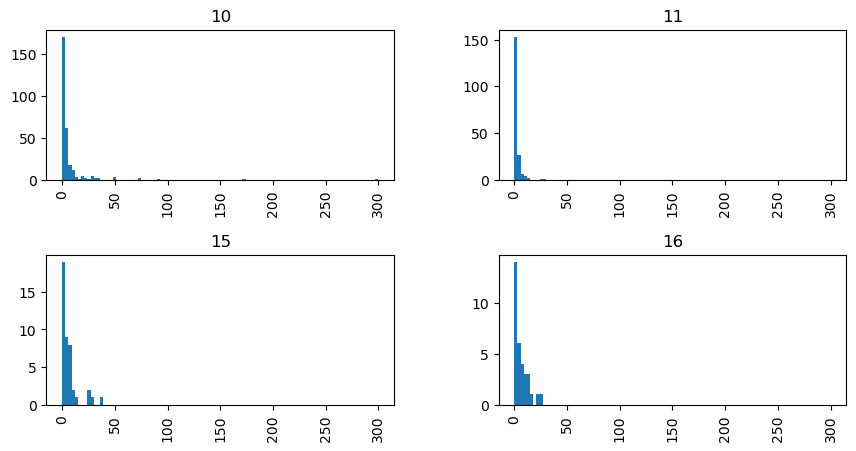

In [7]:
df_audience[
    #               IssueCommentEvent                         IssuesEvent      PullRequestReviewCommentEvent              PullRequestReviewEvent
    (df_audience.event_type_id == 10) | (df_audience.event_type_id == 11) | (df_audience.event_type_id == 15) | (df_audience.event_type_id == 16)
].hist("count", by=["event_type_id"], bins=100, range=(0, 300), figsize=(10, 5));

Very different distributions between the audience (above) and the authors.

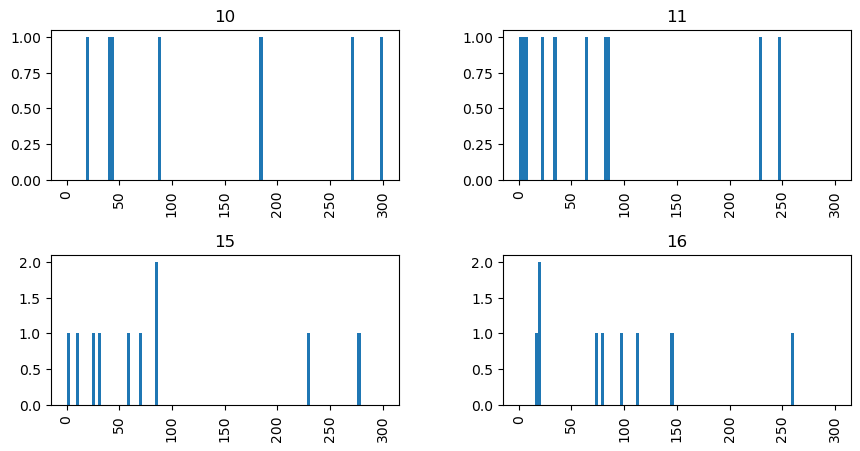

In [8]:
df_author[
    #            IssueCommentEvent                       IssuesEvent     PullRequestReviewCommentEvent            PullRequestReviewEvent
    (df_author.event_type_id == 10) | (df_author.event_type_id == 11) | (df_author.event_type_id == 15) | (df_author.event_type_id == 16)
].hist("count", by=["event_type_id"], bins=100, range=(0, 300), figsize=(10, 5));

Still selecting these comment event types, but aggregating over them. Just the audience below.

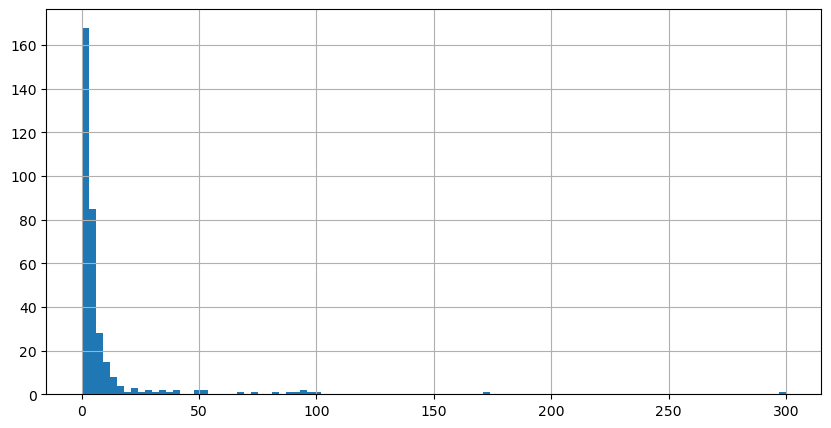

In [9]:
df_audience[
    #               IssueCommentEvent                         IssuesEvent      PullRequestReviewCommentEvent              PullRequestReviewEvent
    (df_audience.event_type_id == 10) | (df_audience.event_type_id == 11) | (df_audience.event_type_id == 15) | (df_audience.event_type_id == 16)
].groupby("actor_id")["count"].sum().hist(bins=100, range=(0, 300), figsize=(10, 5));

Just the authors below.

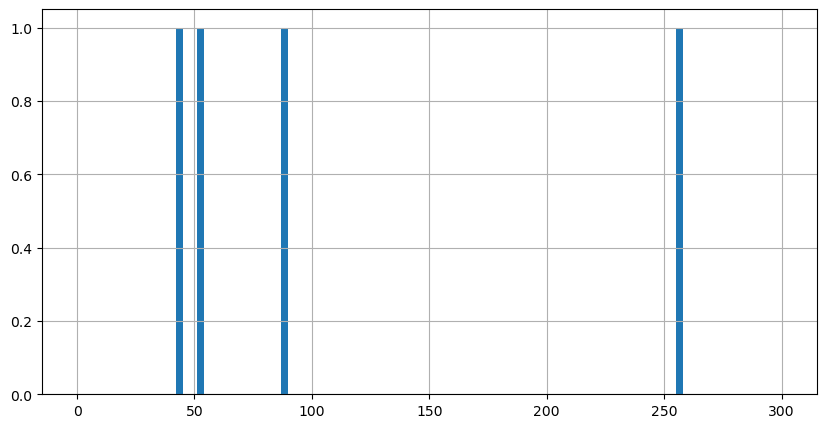

In [10]:
df_author[
    #            IssueCommentEvent                       IssuesEvent     PullRequestReviewCommentEvent            PullRequestReviewEvent
    (df_author.event_type_id == 10) | (df_author.event_type_id == 11) | (df_author.event_type_id == 15) | (df_author.event_type_id == 16)
].groupby("actor_id")["count"].sum().hist(bins=100, range=(0, 300), figsize=(10, 5));

Zoom in on the audience to see where one might cut the peak.

In [11]:
df_audience[
    #               IssueCommentEvent                         IssuesEvent      PullRequestReviewCommentEvent              PullRequestReviewEvent
    (df_audience.event_type_id == 10) | (df_audience.event_type_id == 11) | (df_audience.event_type_id == 15) | (df_audience.event_type_id == 16)
].groupby("actor_id")["count"].sum()

actor_id
8851         2
23151        1
45071        7
52753        2
54418        1
            ..
98302868     7
101270230    1
112505512    1
120186729    2
127864190    2
Name: count, Length: 337, dtype: uint32

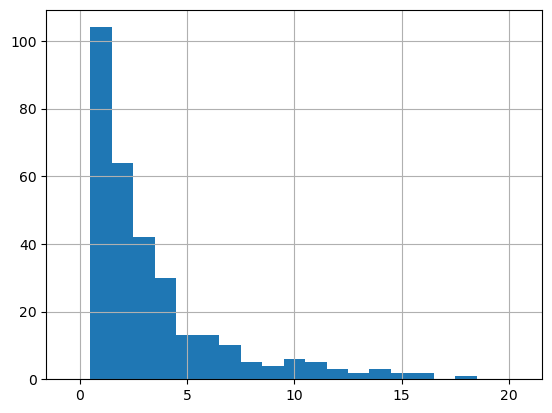

In [12]:
df_audience[
    #               IssueCommentEvent                         IssuesEvent      PullRequestReviewCommentEvent              PullRequestReviewEvent
    (df_audience.event_type_id == 10) | (df_audience.event_type_id == 11) | (df_audience.event_type_id == 15) | (df_audience.event_type_id == 16)
].groupby("actor_id")["count"].sum().hist(bins=21, range=(-0.5, 20.5));

Okay, back to the big data sample, but get rid of bots and all events other than comments.

In [ ]:
def df

In [2]:
bot_actors = np.array(
    [
        int(line.split(b"\t")[0])
        for line in subprocess.Popen(
            [
                "fgrep",
                "[bot]",
                "/home/jpivarski/storage/data/GHArchive/actor_id_name.txt",
            ],
            stdout=subprocess.PIPE,
        )
        .communicate()[0]
        .split(b"\n")
        if line != b""
    ]
)

In [3]:
dfs = [
    pd.DataFrame(dict(h5py.File(filename, "r")))
    for filename in sorted(
        glob.glob("/home/jpivarski/storage/data/GHArchive/GHArchive-*-aggregated.h5")
    )
]
dfs = [df[(~df.actor_id.isin(bot_actors)) & (df.event_type_id.isin([10, 11, 15, 16]))] for df in dfs]
df = pd.concat(dfs, ignore_index=True)
del dfs

In [6]:
actor_repo = df.groupby(["actor_id", "repo_id"])["count"].sum()

In [7]:
actor_repo

actor_id   repo_id  
0          31659554     1
           32611596     4
           41881900     1
           42009758     1
           54378638     1
                       ..
132236041  14779007     1
132236151  626084870    1
132236265  499184667    2
132236310  462771409    1
132236517  560704231    1
Name: count, Length: 53220123, dtype: uint32

How many comments does an actor typically leave on a repo?

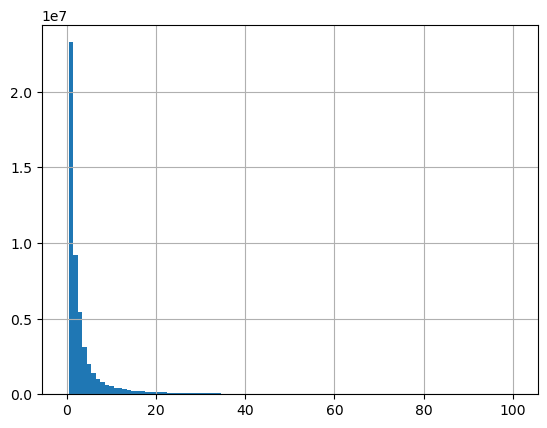

In [25]:
actor_repo.hist(bins=101, range=(-0.5, 100.5));

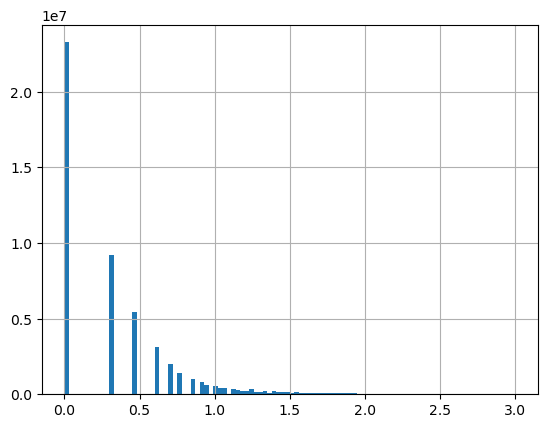

In [26]:
np.log10(actor_repo).hist(bins=100, range=(0, 3));

In [11]:
num_comments_by_actor = actor_repo.reset_index().groupby("actor_id")["count"].sum()

How many comments does an actor typically leave at all (summed over repos)?

<Axes: >

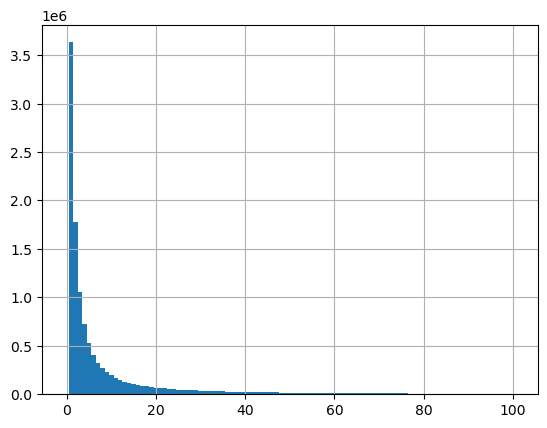

In [18]:
num_comments_by_actor.hist(bins=101, range=(-0.5, 100.5))

<Axes: >

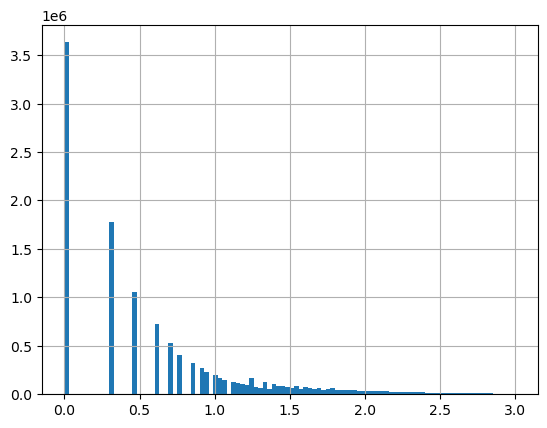

In [20]:
np.log10(num_comments_by_actor).hist(bins=100, range=(0, 3))

Some actors only comment on one repo (peak at 1). Most spread their comments around to at least 10 (peak near 0).

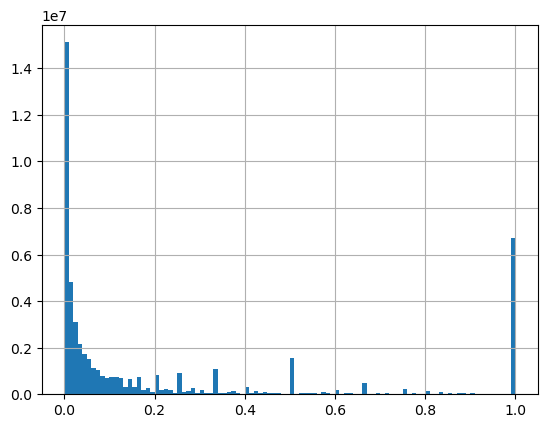

In [13]:
actor_repo.div(num_comments_by_actor, axis=0, level=0).hist(bins=100, range=(0, 1));